
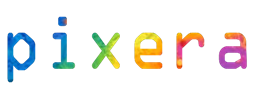
*   The 1st GAN Example that has been prepared by pixera.
*   Dataset : https://www.kaggle.com/soumikrakshit/anime-faces
*   Author: Alican Akca (https://github.com/AlicanAKCA)
*   Note: I have never watched Anime, don't ask this question. :)
*   You can reach pretrained model and epoch results on my [Kaggle Notebook](https://www.kaggle.com/alicanakca/gan-example)
 

In [ ]:
import os 
import cv2
import keras
import warnings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization



In [ ]:
os.chdir("/")

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
!rm -rf kaggle/working/results

In [ ]:
os.makedirs('kaggle/working/results')
os.makedirs('kaggle/working/results/generators')
os.makedirs('kaggle/working/results/pixed_faces')
os.makedirs('kaggle/working/results/discriminators')

In [ ]:
faces = os.listdir("kaggle/input/anime-faces/data")

In [ ]:
len(faces)

21552

In [ ]:
def toThePixL(square):
  for index, face in enumerate(faces):
    if face == "data":
        pass
    else:
        img = Image.open("kaggle/input/anime-faces/data/"+ face)
        img = img.convert("RGB")
        img = img.resize((64, 64), Image.LANCZOS)
        ImgW, ImgH = img.size
        epicAlgorithm(square,ImgW,ImgH,face,img)

In [ ]:
def numOfSquaresFunc(square: int,ImgW,ImgH):
  numOfSquaresW = round((ImgW / square) - 1)
  numOfSquaresH = round((ImgH / square) - 1)
  return (numOfSquaresW,numOfSquaresH) , square, square//2

In [ ]:
def epicAlgorithm(square: int,ImgW,ImgH,face,img):
  pixValues = []

  for j in range(1,numOfSquaresFunc(square,ImgW,ImgH)[0][1]+1):

    for i in range(1,numOfSquaresFunc(square,ImgW,ImgH)[0][0]+1):
      
      pixValues.append((img.getpixel((
            i * numOfSquaresFunc(square,ImgW,ImgH)[1] - numOfSquaresFunc(square,ImgW,ImgH)[2],
            j * numOfSquaresFunc(square,ImgW,ImgH)[1]- numOfSquaresFunc(square,ImgW,ImgH)[2])),
            (i * numOfSquaresFunc(square,ImgW,ImgH)[1] - numOfSquaresFunc(square,ImgW,ImgH)[2],
            j * numOfSquaresFunc(square,ImgW,ImgH)[1] - numOfSquaresFunc(square,ImgW,ImgH)[2])))
 
  background = 255 * np.ones(shape=[ImgW - numOfSquaresFunc(square,ImgW,ImgH)[1], ImgH - numOfSquaresFunc(square,ImgW,ImgH)[1], 3], dtype=np.uint8)         
  
  for pen in range(len(pixValues)):
    
    cv2.rectangle(background, pt1=(pixValues[pen][1][0]-numOfSquaresFunc(square,ImgW,ImgH)[2],pixValues[pen][1][1]-numOfSquaresFunc(square,ImgW,ImgH)[2]), 
                  pt2=(pixValues[pen][1][0]+numOfSquaresFunc(square,ImgW,ImgH)[2],pixValues[pen][1][1]+numOfSquaresFunc(square,ImgW,ImgH)[2]), 
                  color=(pixValues[pen][0][0],pixValues[pen][0][1],pixValues[pen][0][2]), thickness=-1)
  cv2.imwrite("kaggle/working/results/pixed_faces/"+ face, cv2.cvtColor(background, cv2.COLOR_RGB2BGR,background))

In [ ]:
toThePixL(4)

In [ ]:
images = []
def load_images(size=(64,64)):
  pixed_faces =  os.listdir("kaggle/working/results/pixed_faces")
  images_Path = "kaggle/working/results/pixed_faces"
  for i in pixed_faces:
    try:
      image = cv2.imread(f"{images_Path}/{i}")
      image = cv2.resize(image,size)
      images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    except:
      pass

In [ ]:
load_images()

In [ ]:
len(images)

21551

In [ ]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    def build_generator(self):
        epsilon = 0.00001
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)


            

            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))


            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            

            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            if epoch % save_images == 0:
                self.save_images(epoch)
            

            if epoch % save_model == 0:
                self.generator.save("kaggle/working/results/generators/generator_%d" % epoch)
                self.discriminator.save("kaggle/working/results/discriminators/discriminator_%d" % epoch)


    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("kaggle/working/results/pandaS_%d.png" % epoch)
        plt.close()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 128)       0

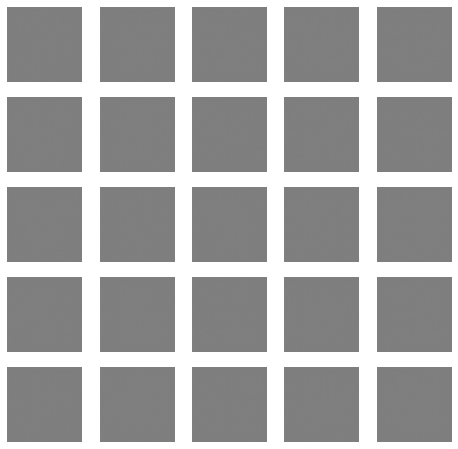

200 [Discriminator loss: 0.218376, acc.: 92.46%] [Generator loss: 2.768589]
400 [Discriminator loss: 0.245896, acc.: 91.48%] [Generator loss: 3.346352]
600 [Discriminator loss: 0.154995, acc.: 94.56%] [Generator loss: 4.211050]
800 [Discriminator loss: 0.202997, acc.: 93.02%] [Generator loss: 4.968430]
1000 [Discriminator loss: 0.201620, acc.: 92.93%] [Generator loss: 5.189505]


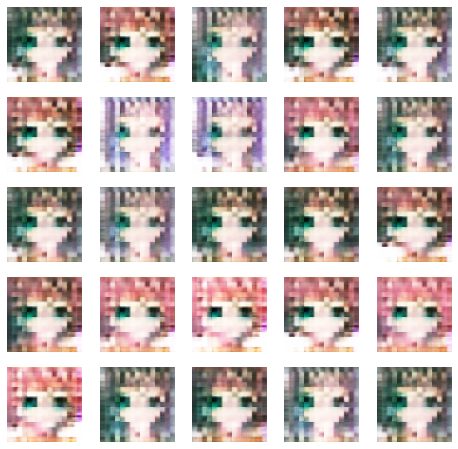

1200 [Discriminator loss: 0.195549, acc.: 92.61%] [Generator loss: 5.776124]
1400 [Discriminator loss: 0.190780, acc.: 93.22%] [Generator loss: 5.221057]
1600 [Discriminator loss: 0.191557, acc.: 93.17%] [Generator loss: 5.171147]
1800 [Discriminator loss: 0.163772, acc.: 94.26%] [Generator loss: 5.549535]
2000 [Discriminator loss: 0.197463, acc.: 93.42%] [Generator loss: 4.655454]


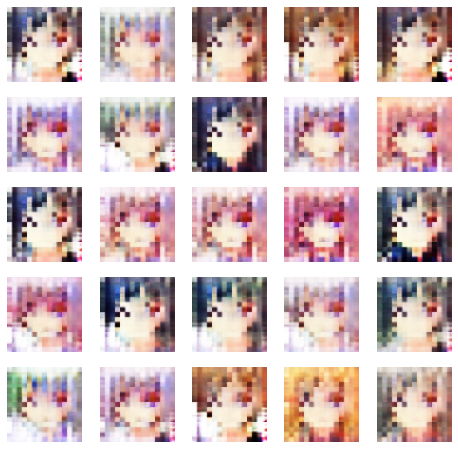

2200 [Discriminator loss: 0.131313, acc.: 95.53%] [Generator loss: 5.065406]
2400 [Discriminator loss: 0.155977, acc.: 94.72%] [Generator loss: 5.793194]
2600 [Discriminator loss: 0.172847, acc.: 94.44%] [Generator loss: 5.258221]
2800 [Discriminator loss: 0.236093, acc.: 93.47%] [Generator loss: 4.984569]
3000 [Discriminator loss: 0.146733, acc.: 95.17%] [Generator loss: 5.142453]


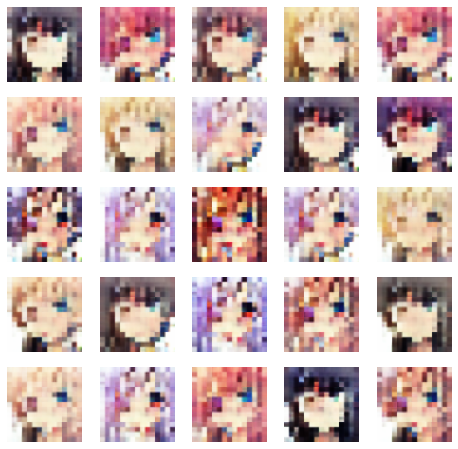

3200 [Discriminator loss: 0.178589, acc.: 94.20%] [Generator loss: 5.343012]
3400 [Discriminator loss: 0.157873, acc.: 94.40%] [Generator loss: 5.714533]
3600 [Discriminator loss: 0.188122, acc.: 94.41%] [Generator loss: 5.710845]
3800 [Discriminator loss: 0.185475, acc.: 94.72%] [Generator loss: 5.821347]
4000 [Discriminator loss: 0.157010, acc.: 94.76%] [Generator loss: 5.567010]


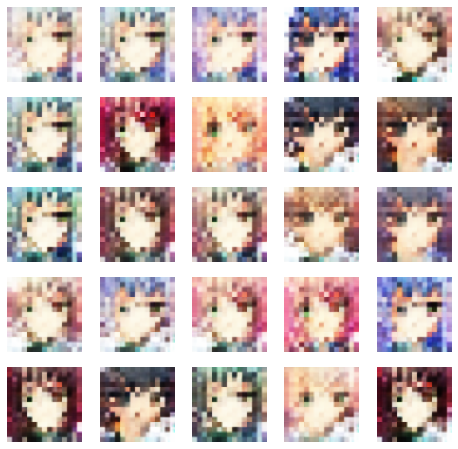

4200 [Discriminator loss: 0.154188, acc.: 95.59%] [Generator loss: 5.259056]
4400 [Discriminator loss: 0.168353, acc.: 94.52%] [Generator loss: 5.359258]
4600 [Discriminator loss: 0.134462, acc.: 95.82%] [Generator loss: 5.757890]
4800 [Discriminator loss: 0.151136, acc.: 95.71%] [Generator loss: 6.189709]
5000 [Discriminator loss: 0.111266, acc.: 96.35%] [Generator loss: 6.551163]


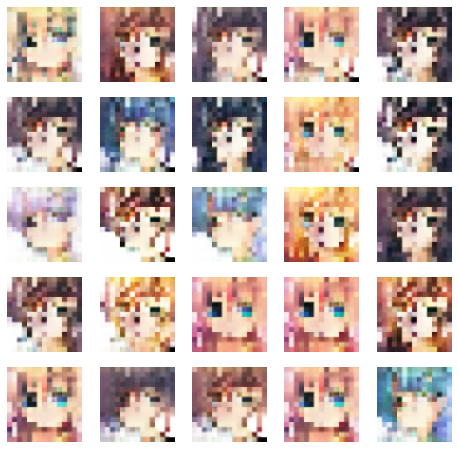

5200 [Discriminator loss: 0.140731, acc.: 95.85%] [Generator loss: 6.332743]
5400 [Discriminator loss: 0.178283, acc.: 95.09%] [Generator loss: 6.052549]
5600 [Discriminator loss: 0.128307, acc.: 96.13%] [Generator loss: 6.338331]
5800 [Discriminator loss: 0.181099, acc.: 95.67%] [Generator loss: 6.119106]
6000 [Discriminator loss: 0.121563, acc.: 96.33%] [Generator loss: 6.237845]


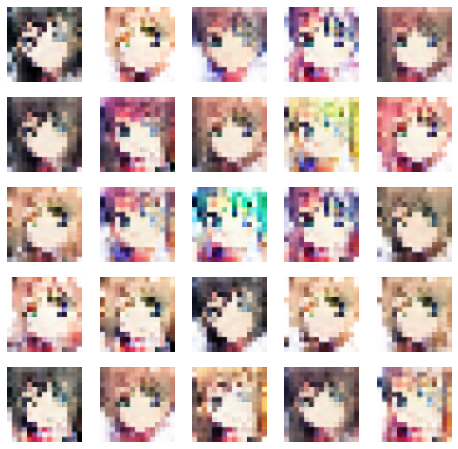

6200 [Discriminator loss: 0.152801, acc.: 95.78%] [Generator loss: 6.268922]
6400 [Discriminator loss: 0.145488, acc.: 95.94%] [Generator loss: 6.187219]
6600 [Discriminator loss: 0.158000, acc.: 95.41%] [Generator loss: 5.484285]
6800 [Discriminator loss: 0.142786, acc.: 95.78%] [Generator loss: 6.026818]
7000 [Discriminator loss: 0.202601, acc.: 94.79%] [Generator loss: 5.772689]


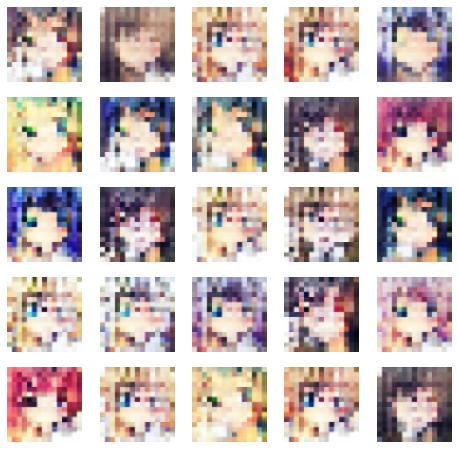

7200 [Discriminator loss: 0.131619, acc.: 95.85%] [Generator loss: 6.206335]
7400 [Discriminator loss: 0.202665, acc.: 95.12%] [Generator loss: 5.589725]
7600 [Discriminator loss: 0.146647, acc.: 95.64%] [Generator loss: 6.452137]
7800 [Discriminator loss: 0.128784, acc.: 96.02%] [Generator loss: 6.011922]
8000 [Discriminator loss: 0.119401, acc.: 96.48%] [Generator loss: 6.657687]


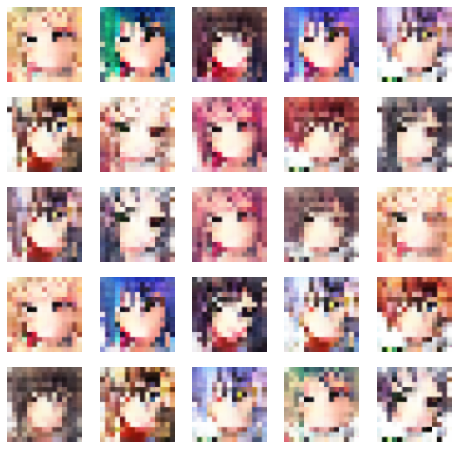

8200 [Discriminator loss: 0.145612, acc.: 96.19%] [Generator loss: 6.070119]
8400 [Discriminator loss: 0.174490, acc.: 95.70%] [Generator loss: 5.926736]
8600 [Discriminator loss: 0.135065, acc.: 96.15%] [Generator loss: 6.129507]
8800 [Discriminator loss: 0.143381, acc.: 96.41%] [Generator loss: 5.986704]
9000 [Discriminator loss: 0.168825, acc.: 95.71%] [Generator loss: 5.384777]


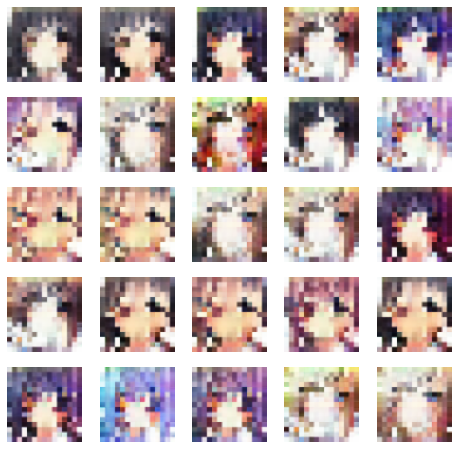

9200 [Discriminator loss: 0.117584, acc.: 96.49%] [Generator loss: 5.773699]
9400 [Discriminator loss: 0.236439, acc.: 93.97%] [Generator loss: 5.460469]
9600 [Discriminator loss: 0.145998, acc.: 96.34%] [Generator loss: 5.602064]
9800 [Discriminator loss: 0.195766, acc.: 95.23%] [Generator loss: 5.042998]
10000 [Discriminator loss: 0.187566, acc.: 94.73%] [Generator loss: 5.415597]


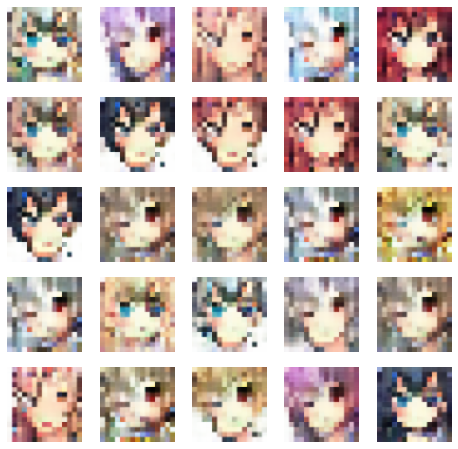

10200 [Discriminator loss: 0.185590, acc.: 95.08%] [Generator loss: 5.726825]
10400 [Discriminator loss: 0.179091, acc.: 94.94%] [Generator loss: 5.760252]
10600 [Discriminator loss: 0.150694, acc.: 95.52%] [Generator loss: 5.607616]
10800 [Discriminator loss: 0.172346, acc.: 95.64%] [Generator loss: 5.689616]
11000 [Discriminator loss: 0.130625, acc.: 96.64%] [Generator loss: 5.905005]


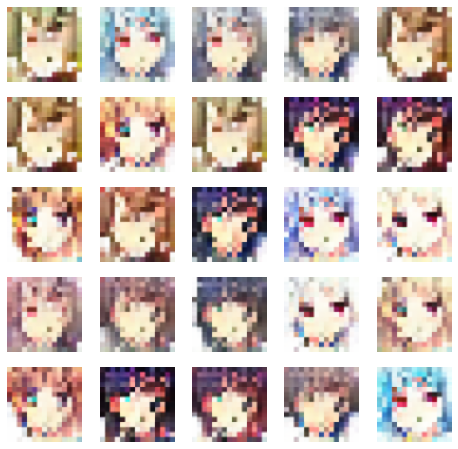

11200 [Discriminator loss: 0.126758, acc.: 96.47%] [Generator loss: 6.982037]
11400 [Discriminator loss: 0.152655, acc.: 96.07%] [Generator loss: 6.044185]
11600 [Discriminator loss: 0.102549, acc.: 97.15%] [Generator loss: 6.489016]
11800 [Discriminator loss: 0.164631, acc.: 95.98%] [Generator loss: 6.128717]
12000 [Discriminator loss: 0.112043, acc.: 97.00%] [Generator loss: 6.813679]


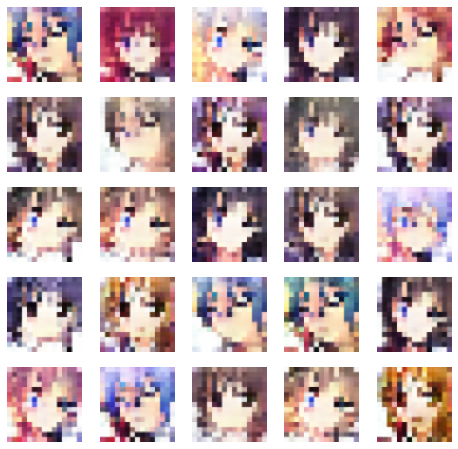

12200 [Discriminator loss: 0.132641, acc.: 96.90%] [Generator loss: 6.143207]
12400 [Discriminator loss: 0.106842, acc.: 97.04%] [Generator loss: 5.510709]
12600 [Discriminator loss: 0.136811, acc.: 96.66%] [Generator loss: 5.510814]
12800 [Discriminator loss: 0.132673, acc.: 96.62%] [Generator loss: 6.356228]
13000 [Discriminator loss: 0.139807, acc.: 96.78%] [Generator loss: 5.828896]


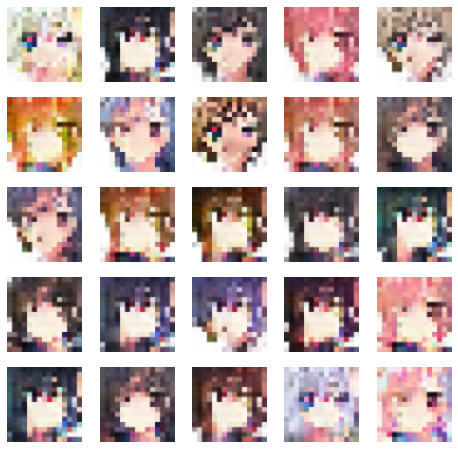

13200 [Discriminator loss: 0.174413, acc.: 95.51%] [Generator loss: 6.133577]
13400 [Discriminator loss: 0.128582, acc.: 96.40%] [Generator loss: 5.788930]
13600 [Discriminator loss: 0.145171, acc.: 95.83%] [Generator loss: 6.004937]
13800 [Discriminator loss: 0.180835, acc.: 95.83%] [Generator loss: 5.757730]
14000 [Discriminator loss: 0.126811, acc.: 96.28%] [Generator loss: 5.287354]


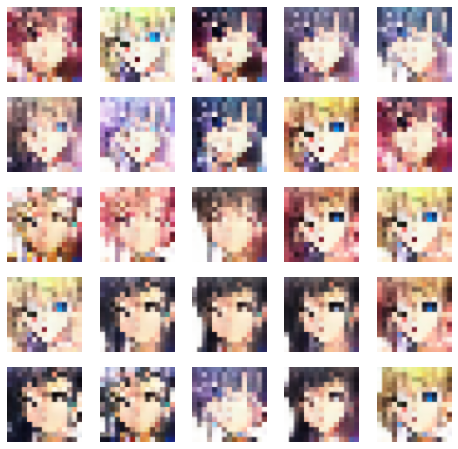

14200 [Discriminator loss: 0.139558, acc.: 96.35%] [Generator loss: 5.761392]
14400 [Discriminator loss: 0.181106, acc.: 95.36%] [Generator loss: 6.320267]
14600 [Discriminator loss: 0.157897, acc.: 96.31%] [Generator loss: 5.686893]
14800 [Discriminator loss: 0.121529, acc.: 97.32%] [Generator loss: 6.031311]
15000 [Discriminator loss: 0.084581, acc.: 97.80%] [Generator loss: 5.875925]


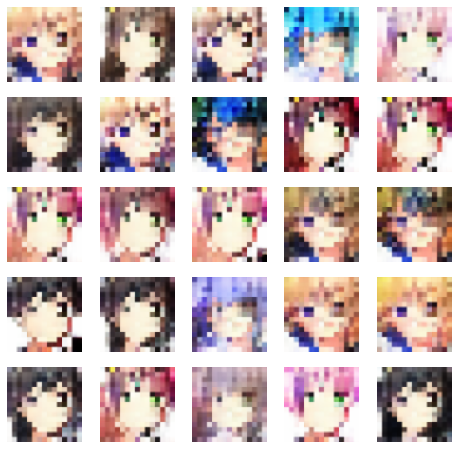

In [ ]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)